#### **Problem Statement**
Ship or vessel detection has a wide range of applications, in the areas of maritime safety, fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc.

Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project.

There are 5 classes of ships to be detected.

**Dataset Description**
There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

'Cargo' -> 1
'Military' -> 2
'Carrier' -> 3
'Cruise' -> 4
'Tankers' -> 5

There are three files provided to you, viz train.zip, test.csv and sample_submission.csv which have the following structure.

Variable	   Definition
image	    :  Name of the image in the dataset (ID column)
category	:  Ship category code (target column)

train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv

**Evaluation Metric**
The Evaluation metric for this competition is weighted F1 Score

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from tqdm import tqdm
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission_ns2btKE.csv', 'train', 'test_ApKoW4T.csv']


In [2]:
### install some cool stuff
! pip install albumentations    #### for augmentations that work faster
! pip install pytorchcv         #### More pre-trained models

    100% |████████████████████████████████| 71kB 6.3MB/s 
    100% |████████████████████████████████| 20.0MB 2.5MB/s 
    100% |████████████████████████████████| 634kB 20.5MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/a5/9e/e7/4fba91d20a05120f4031ebb751f95a2dfe6b305d680ca1fe9f
  Stored in directory: /tmp/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.8
    Uninstalling imgaug-0.2.8:
      Successfully uninstalled imgaug-0.2.8
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 368kB 15.7MB/s 
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time 
import tqdm
import random
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2

import albumentations
from albumentations import torch as AT
#import pretrainedmodels

import scipy.special

from pytorchcv.model_provider import get_model as ptcv_get_model

cudnn.benchmark = True

In [4]:
#### Need to seed everything so we can reproduce results as well
SEED = 323
base_dir = '../input/'
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

In [5]:
### Taking a look at folder and file structure 
!ls '../input/'


sample_submission_ns2btKE.csv  test_ApKoW4T.csv  train


In [6]:
### images are @ : '../input/train/images/' has both train+test images 
### Train Labels along with image ID is @: '../input/train/train.csv'
### Test file with test image IDs '../input/test_ApKoW4T.csv'

In [7]:
### read labels/image 
labels = pd.read_csv(base_dir+'/train/train.csv')
labels.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


### Quick EDA

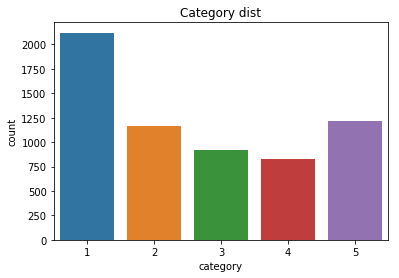

In [8]:
#### Label Distribution:
import seaborn as sns
labels['category'].value_counts()
sns.countplot(x='category' , data=labels)
plt.title("Category dist")
plt.show();

In [9]:
## mapping the ship categories  
category = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

In [10]:
### preparing some useful stuff for easy vizualizations later on
Rev = dict((v,k) for k,v in category.items())  ### need to reverse
caT = pd.DataFrame(labels['category'].map(Rev))
caT.rename(columns={'category': "CategoryText"},inplace=True)
caT = pd.concat([labels,pd.DataFrame(caT)],1)
caT.head()

,image,category,CategoryText
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [11]:
from random import sample
import cv2
import matplotlib.image as mpimg

def plotClass(category,N):
    categoryIdx = caT[caT['CategoryText']==category].index[:30]
    randIdx = sample(list(categoryIdx),N)
    jpegName = caT.iloc[randIdx,:]['image'].values
    fig = plt.figure(figsize=(18,14))
    for i , jpeg in enumerate(list(jpegName)):
        plt.subplot(1,N ,i+1)
        imgFile = mpimg.imread('../input/train/images/{}'.format(jpeg))
        plt.imshow(imgFile)

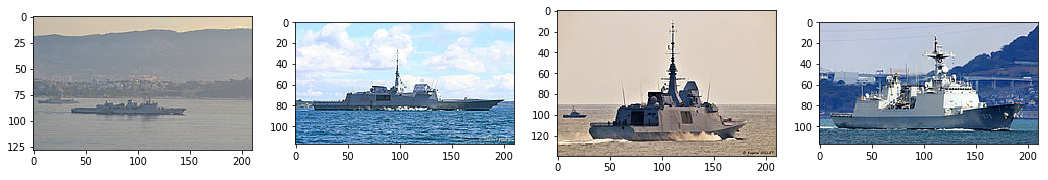

In [12]:
plotClass("Military",4)

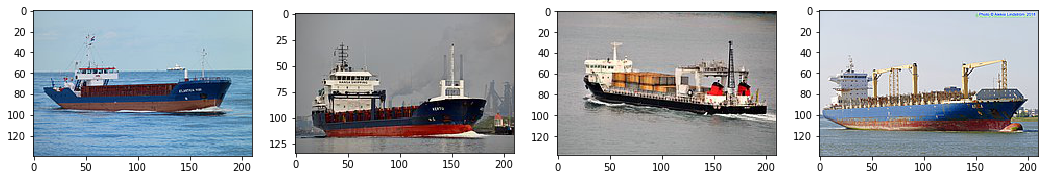

In [13]:
plotClass("Cargo",4)

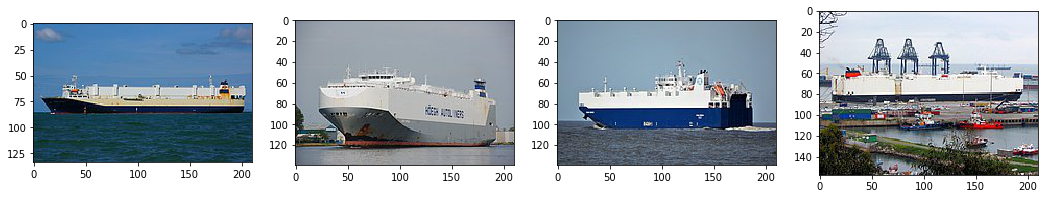

In [14]:
plotClass("Carrier",4)

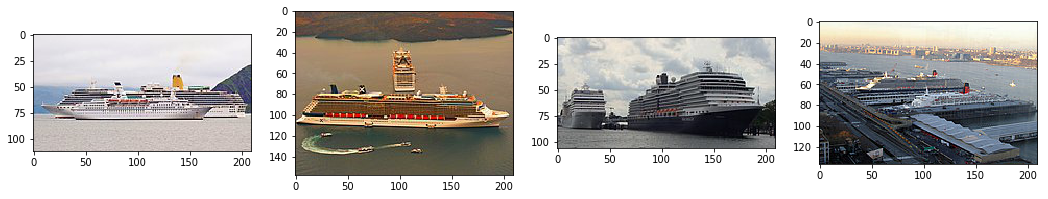

In [15]:
plotClass("Cruise",4)

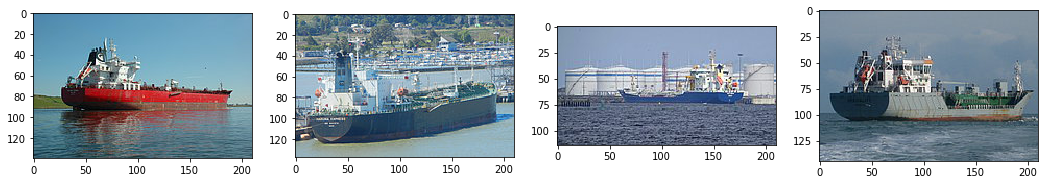

In [16]:
plotClass("Tankers",4)

In [17]:
### different sized images, vertical flipping does not make sense as these are front on/hortizontal pictures
### left-to-right flip can be considered augmentation

In [18]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [19]:
y, le_full = prepare_labels(labels['category'])
y.shape

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(6252, 5)

In [20]:
y[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
labels['category'][:5]

0    1
1    1
2    2
3    3
4    2
Name: category, dtype: int64

In [22]:
### map imge names to labels
img_class_dict = {k:v for k, v in zip(labels.image, labels.category)}
img_class_dict

{'2823080.jpg': 1,
 '2870024.jpg': 1,
 '2662125.jpg': 2,
 '2900420.jpg': 3,
 '2804883.jpg': 2,
 '621252.jpg': 4,
 '2833467.jpg': 1,
 '2843780.jpg': 5,
 '2859567.jpg': 3,
 '2896557.jpg': 1,
 '2847618.jpg': 3,
 '2874678.jpg': 3,
 '2903279.jpg': 3,
 '2892401.jpg': 1,
 '2891158.jpg': 2,
 '2896519.jpg': 5,
 '2870078.jpg': 1,
 '2845743.jpg': 5,
 '2692646.jpg': 2,
 '2839660.jpg': 5,
 '2868091.jpg': 3,
 '2812909.jpg': 1,
 '2862039.jpg': 1,
 '2890672.jpg': 3,
 '2874072.jpg': 1,
 '2785048.jpg': 2,
 '683110.jpg': 2,
 '2877843.jpg': 3,
 '2872097.jpg': 1,
 '2710618.jpg': 4,
 '1414706.jpg': 4,
 '2839562.jpg': 1,
 '2896605.jpg': 5,
 '2845690.jpg': 1,
 '947703.jpg': 2,
 '2816830.jpg': 5,
 '2845772.jpg': 5,
 '2904591.jpg': 5,
 '2880224.jpg': 1,
 '2653226.jpg': 4,
 '2809869.jpg': 2,
 '2819017.jpg': 1,
 '2849471.jpg': 2,
 '2819587.jpg': 2,
 '2843653.jpg': 5,
 '2818966.jpg': 5,
 '2408177.jpg': 2,
 '2899497.jpg': 3,
 '2560213.jpg': 2,
 '2849863.jpg': 1,
 '2810838.jpg': 5,
 '2838423.jpg': 3,
 '2100454.jpg':

In [23]:
### DataLoader
from PIL import Image

class ShipDataLoader(torch.utils.data.DataLoader):
    def __init__(self,CSVfolder = '../input/train/train.csv',process='train',transform = transforms.Compose([transforms.CenterCrop(64),transforms.ToTensor()]),
                 imgFolder='../input/train/images/',labelsDict = {},y=y):
        self.process = process
        self.imgFolder = imgFolder
        self.CSVfolder = CSVfolder
        self.y = y
        self.FileList = pd.read_csv(self.CSVfolder)['image'].tolist()
        self.transform = transform
        self.labelsDict = labelsDict
        
        if self.process =='train':
            self.labels = [labelsDict[i] for i in self.FileList]
        else:
            self.labels = [0 for i in range(len(self.FileList))]

    def __len__(self):
        return len(self.FileList)
    
    def __getitem__(self,idx):
        fname =  self.FileList[idx]
        img_name = os.path.join(self.imgFolder, fname)
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.process == 'train':
            label = self.y[idx]
        else:
            label = np.zeros((5,))
        return image, label

In [24]:
### Augmentations from albumenations
sz = 224

data_transforms = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.0),
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2), albumentations.IAASharpen(), albumentations.IAAEmboss(), 
        albumentations.RandomBrightness(), albumentations.RandomContrast(),
        albumentations.JpegCompression(), albumentations.Blur(), albumentations.GaussNoise()], p=0.5), 
    albumentations.HueSaturationValue(p=0.5), 
    albumentations.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_tta0 = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_tta1 = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.RandomRotate90(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_tta2 = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.Transpose(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_tta3 = albumentations.Compose([
    albumentations.Resize(sz, sz),
    albumentations.HorizontalFlip(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

In [25]:
#### 90-10 train-validation split
tr, val = train_test_split(labels.category, stratify=labels.category, test_size=0.1, random_state=42)

### Batchsize and parallelize

BS = 64
num_workers = 8

#### Idx for train and valid
train_sampler = SubsetRandomSampler(list(tr.index)) 
valid_sampler = SubsetRandomSampler(list(val.index))

#### Train dataloader ####
traindataset = ShipDataLoader(transform = data_transforms,
                              imgFolder='../input/train/images/',process='train',
                              labelsDict = img_class_dict,y=y)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=BS,sampler=train_sampler,num_workers=num_workers)

#### Valid dataloader ####

valdataset = ShipDataLoader(transform = data_transforms_test,
                              imgFolder='../input/train/images/',process='train',
                              labelsDict = img_class_dict,y=y)
val_loader = torch.utils.data.DataLoader(valdataset, batch_size=BS,sampler=valid_sampler,num_workers=num_workers)

#### Test dataloader ####

testdataset = ShipDataLoader(transform = data_transforms_test,
                              imgFolder='../input/train/images/',process='test',
                              labelsDict = img_class_dict,y=y)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers)

In [26]:
nclass = labels['category'].nunique()
nclass

5

In [27]:
modName = 'SENet154'
model_conv = ptcv_get_model(modName, pretrained=True)

### set all weight to be not trainable
for param in model_conv.parameters():
    param.requires_grad = False

def count_parameters(model):
    '''
    Count of trainable weights in a model
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_conv)

0

In [28]:
model_conv

SENet(
  (features): Sequential(
    (init_block): SEInitBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): SENetUnit(
        (body): SENetBottlene

In [29]:
parent_counter = 0
for child in model_conv.children():
    child_counter = 0
    for c in child.children():
        child_counter += 1
        print("Parent: ",parent_counter,"Child: ",child_counter)
    parent_counter += 1

Parent:  0 Child:  1
Parent:  0 Child:  2
Parent:  0 Child:  3
Parent:  0 Child:  4
Parent:  0 Child:  5
Parent:  0 Child:  6
Parent:  1 Child:  1
Parent:  1 Child:  2


In [30]:
### unfreeze the few last layers of SENET154 models; based only only flattened hierarchy

def unfreeze(n):
    child_child_counter = 0
    for child in model_conv.children():
        for c in child.children():
            if child_child_counter > n:
                for param in c.parameters():
                    param.requires_grad = True
            child_child_counter += 1
            
            
def freeze(n):
    child_child_counter = 0
    for child in model_conv.children():
        for c in child.children():
            if (child_child_counter > n) and (child_child_counter <= 4):
                for param in c.parameters():
                    param.requires_grad = False
            else:
                break
            child_child_counter += 1

unfreeze(4)            
count_parameters(model_conv)

2049000

In [31]:
### We need to replace the last FC layer and then add custom head
model_conv.output

Sequential(
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

In [32]:
d = 0.
model_conv.output = nn.Sequential(nn.Dropout(d), nn.Linear(in_features=2048, out_features=1024, bias=True), nn.SELU(),
                                     nn.Dropout(d),nn.Linear(in_features=1024, out_features=512, bias=True), nn.SELU(), nn.Dropout(d), 
                                  nn.Linear(in_features=512, out_features=nclass, bias=True))

In [33]:
list(model_conv.output.children())

[Dropout(p=0.0),
 Linear(in_features=2048, out_features=1024, bias=True),
 SELU(),
 Dropout(p=0.0),
 Linear(in_features=1024, out_features=512, bias=True),
 SELU(),
 Dropout(p=0.0),
 Linear(in_features=512, out_features=5, bias=True)]

In [34]:
count_parameters(model_conv)

2625541

### Model Training

In [35]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss() ### numerically stable as compared to BCELoss
optimizer = optim.Adam(model_conv.parameters(), lr=1e-4)  ### will only consider the newly added FC and the unfrozen  block weight
scheduler = StepLR(optimizer, 5, gamma=0.2)
scheduler_cosineAL = lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader), eta_min=1e-6)

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
from sklearn.metrics import f1_score
useCosine = True
model_conv.cuda()
n_epochs = 100
layerWiseFreeze = False
patience = 25
# current number of tests, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# Show batch f1 results
batchRes = False

## loss lists
loss_list = []
train_f1_avg=[]
val_f1_avg = []
val_f1_max=0

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    
    if epoch == 10:
            n = 3
            unfreeze(n)
            
    if layerWiseFreeze:
        if epoch == 5:
            n = 3
            unfreeze(n)
            print("Unfreezing layers from {} grouping onwards".format(n))
        elif epoch == 10:
            freeze(n)
            print("Freezing layers from {} grouping onwards".format(n))
        elif epoch == 15:
            unfreeze(n)
            print("Unfreezing layers from {} grouping onwards".format(n))
    
    train_loss_epoch = []
    val_loss_epoch = []
    train_f1_epoch = []
    val_f1_epoch = []

    if useCosine:
        scheduler_cosineAL.step()
    else:
        scheduler.step()

    for batch_i, (data, target) in  enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model_conv(data)
        
        loss = criterion(output, target.float())
        train_loss_epoch.append(loss.item())

        loss.backward()
        optimizer.step()
        
        a = target.data.cpu().numpy()
        b = output.data.cpu().numpy()
        train_f1_scr_iter = f1_score(np.argmax(a,1),np.argmax(b,1),average='weighted')
        train_f1_epoch.append(train_f1_scr_iter)
        
        if (batch_i+1)%25 == 0:    
            val_loss = []
            model_conv.eval()
            for val_batch_i, (data, target) in enumerate(val_loader):
                data, target = data.cuda(), target.cuda()
                output = model_conv(data)
                loss = criterion(output, target.float())
                val_loss_epoch.append(loss.item()) 
                a1 = target.data.cpu().numpy()
                b1 = output.data.cpu().numpy()
                val_f1_scr_iter = f1_score(np.argmax(a1,1),np.argmax(b1,1),average='weighted')
                val_f1_epoch.append(val_f1_scr_iter)
    if batchRes:
        try:
            print("Batch Val f1",f1_score(np.argmax(a1,1),np.argmax(b1,1),average='weighted'))
        except:
            pass
        
    print("Epoch: {},Train F1: {}, Val F1: {}".format(epoch,np.mean(train_f1_epoch),np.mean(val_f1_epoch)))
    train_f1_epoch.append(np.mean(train_f1_epoch))
    val_f1_avg.append(np.mean(val_f1_epoch))
    
    if np.mean(val_f1_epoch) > val_f1_max:
        print('Validation F1 increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_f1_max,
        np.mean(val_f1_epoch)))
        torch.save(model_conv.state_dict(), 'model.pt')
        val_f1_max = np.mean(val_f1_epoch)
        e  = epoch
        p = 0
    else:
        p += 1
        if p > patience:
            print('Early stop training')
            stop = True
            break

Sat Jun 15 20:16:29 2019 Epoch: 1
Epoch: 1,Train F1: 0.5632318367768824, Val F1: 0.7242259538210695
Validation F1 increased (0.000000 --> 0.724226).  Saving model ...
Sat Jun 15 20:17:59 2019 Epoch: 2
Epoch: 2,Train F1: 0.7576617115501915, Val F1: 0.8012922039160341
Validation F1 increased (0.724226 --> 0.801292).  Saving model ...
Sat Jun 15 20:19:20 2019 Epoch: 3
Epoch: 3,Train F1: 0.7805789285478103, Val F1: 0.8271473390658274
Validation F1 increased (0.801292 --> 0.827147).  Saving model ...
Sat Jun 15 20:20:41 2019 Epoch: 4
Epoch: 4,Train F1: 0.7928377340651088, Val F1: 0.8435760962456436
Validation F1 increased (0.827147 --> 0.843576).  Saving model ...
Sat Jun 15 20:22:01 2019 Epoch: 5
Epoch: 5,Train F1: 0.7970454273943761, Val F1: 0.8445831836266723
Validation F1 increased (0.843576 --> 0.844583).  Saving model ...
Sat Jun 15 20:23:22 2019 Epoch: 6
Epoch: 6,Train F1: 0.7948703894032629, Val F1: 0.8504805104476785
Validation F1 increased (0.844583 --> 0.850481).  Saving model ..

In [38]:
print("Best Val F1 loss:{}, Epoch:{}".format(val_f1_max,e))

Best Val F1 loss:0.962481875223189, Epoch:73


In [39]:
### empty cuda cache
torch.cuda.empty_cache()

### Inference

In [40]:
model_conv.eval()

SENet(
  (features): Sequential(
    (init_block): SEInitBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): SENetUnit(
        (body): SENetBottlene

In [41]:
try:
    saved_dict = torch.load('model.pt')
    model_conv.load_state_dict(saved_dict)
except:
    model_conv.load_state_dict(model_conv.state_dict())

In [42]:
TTA_ITER = 10
from tqdm import tqdm

preds = {}
def getPreds(TTA_ITER):
    for num_tta in tqdm(range(TTA_ITER)):
        iterpreds = []
        if num_tta==0:
            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_test,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers)

        elif num_tta==1:
            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_tta1,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers,shuffle=False)

        elif num_tta==2:
            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_tta2,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers,shuffle=False)

        elif num_tta==3:

            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_tta3,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers,shuffle=False)

        elif num_tta<8:
            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_tta0,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers,shuffle=False)

        else:
            testdataset = ShipDataLoader(CSVfolder='../input/test_ApKoW4T.csv',transform = data_transforms_tta0,
                                  imgFolder='../input/train/images/',process='test',
                                  labelsDict = img_class_dict,y=y)
            test_loader = torch.utils.data.DataLoader(testdataset, batch_size=BS,num_workers=num_workers,shuffle=False)

        for batch_i, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model_conv(data).detach()
            sm = torch.nn.Softmax()
            probabilities = sm(output).data.cpu().numpy()
            iterpreds.append(probabilities)
        preds[num_tta]=iterpreds
        
        
    _1 = [j for i in preds[0] for j in i ]
    flat_list1 = [item for sublist in _1 for item in sublist]
    a1 =np.array(flat_list1).reshape(-1,5)

    _2 = [j for i in preds[1] for j in i ]
    flat_list2 = [item for sublist in _2 for item in sublist]
    a2 =np.array(flat_list2).reshape(-1,5)

    _3 = [j for i in preds[2] for j in i ]
    flat_list3 = [item for sublist in _3 for item in sublist]
    a3 =np.array(flat_list3).reshape(-1,5)

    _4 = [j for i in preds[3] for j in i ]
    flat_list4 = [item for sublist in _4 for item in sublist]
    a4 =np.array(flat_list4).reshape(-1,5)

    _5 = [j for i in preds[4] for j in i ]
    flat_list5 = [item for sublist in _5 for item in sublist]
    a5 =np.array(flat_list5).reshape(-1,5)

    _6 = [j for i in preds[5] for j in i ]
    flat_list6 = [item for sublist in _6 for item in sublist]
    a6 =np.array(flat_list6).reshape(-1,5)

    _7 = [j for i in preds[6] for j in i ]
    flat_list7 = [item for sublist in _7 for item in sublist]
    a7 =np.array(flat_list7).reshape(-1,5)

    _8 = [j for i in preds[7] for j in i ]
    flat_list8 = [item for sublist in _8 for item in sublist]
    a8 =np.array(flat_list8).reshape(-1,5)

    _9 = [j for i in preds[8] for j in i ]
    flat_list9 = [item for sublist in _9 for item in sublist]
    a9 =np.array(flat_list9).reshape(-1,5)

    _10 = [j for i in preds[9] for j in i ]
    flat_list10 = [item for sublist in _10 for item in sublist]
    a10 =np.array(flat_list10).reshape(-1,5)
    
    temp = (a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)/10
    
    labelMAP = {0:1,1:2,2:3,3:4,4:5}
    labelsUPD = np.vectorize(labelMAP.get)(np.argmax(temp,1))
    
    testCSV = pd.read_csv('../input/sample_submission_ns2btKE.csv')
    testCSV['category'] = labelsUPD
    valF1 = val_f1_max
    fname = 'AVsubmission_'+str(modName)+"_"+str(valF1)
    return fname,testCSV

In [43]:
fname,testCSV = getPreds(TTA_ITER=10)
testCSV.to_csv(fname+'.csv',index=False)
from IPython.display import FileLink, FileLinks
FileLink(fname+'.csv')

100%|██████████| 10/10 [04:34<00:00, 27.26s/it]


/kaggle/working/AVsubmission_SENet154_0.962481875223189.csv

### End of code ### 